In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
class FfAgentContinuous(object):
    def __init__(self, session, input_size, output_size, gamma=0.99):
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.gamma = gamma
        
        self.observations_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.input_size])
        # expected sum of discounted rewards
        self.esdr_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        self.v_s_ph  = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s)
        self.v_sp_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s')
        self.r_ph    = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # r_t+1
        self.actions_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.output_size])
        #self.reward_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        
        advantage = self.esdr_ph - self.v_s_ph
        mean_adv = tf.reduce_mean(advantage)
        stddev_adv = tf.sqrt(tf.reduce_mean(advantage*advantage) - mean_adv*mean_adv)
        self.adv_normalized = (advantage - mean_adv)/(stddev_adv + 1e-8)
        
        # Shared-parameter policy and value network
        W1p = tf.get_variable("w1p", [self.input_size, 128], initializer=tf.initializers.random_normal(stddev=0.01))
        b1p = tf.get_variable("b1p", [128], initializer=tf.initializers.random_normal(stddev=0.01))
        W2p_means = tf.get_variable("w2pmeans", [128, self.output_size], initializer=tf.initializers.random_normal(stddev=0.01)) # policy
        W2p_stdevs = tf.get_variable("w2pstdevs", [128, self.output_size], initializer=tf.initializers.random_normal(stddev=0.01)) # policy
        b2p_means = tf.get_variable("b2pmeans", [self.output_size], initializer=tf.initializers.random_normal(stddev=0.01))
        b2p_stdevs = tf.get_variable("b2pstdevs", [self.output_size], initializer=tf.initializers.random_normal(stddev=0.01))
        
        l1p = tf.nn.relu(tf.matmul(self.observations_ph, W1p) + b1p)
        # this will need to be changed to accommodate the range and character of action values
        l2p_means = tf.matmul(l1p, W2p_means) + b2p_means
        # Trying to start with a large standard deviation to encourage exploration early on.
        l2p_stdevs = tf.matmul(l1p, W2p_stdevs) + b2p_stdevs + 7
        l2_policy_means = 2*tf.nn.tanh(l2p_means)
        l2_policy_stdevs = tf.math.minimum(tf.nn.softplus(l2p_stdevs), 10) + 0.01
        
        W1v = tf.get_variable("w1v", [self.input_size, 128], initializer=tf.initializers.random_normal(stddev=0.01))
        b1v = tf.get_variable("b1v", [128], initializer=tf.initializers.random_normal(stddev=0.01))
        W2v = tf.get_variable("w2v", [128, 1], initializer=tf.initializers.random_normal(stddev=0.01)) # value
        b2v = tf.get_variable("b2v", [1], initializer=tf.initializers.random_normal(stddev=0.01))
        
        l1v = tf.nn.relu(tf.matmul(self.observations_ph, W1v) + b1v)
        l2v = tf.matmul(l1v, W2v) + b2v
        
        self.reinforce_loss = tf.reduce_mean(
            (self.esdr_ph)*tf.square((self.actions_ph - l2_policy_means)/(l2_policy_stdevs + 1e-8))
            - 0.01*tf.log(l2_policy_stdevs)
        )
        self.reinforce_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.reinforce_loss)
        
        self.actor_loss = tf.reduce_mean(
            (self.adv_normalized)*tf.square((self.actions_ph - l2_policy_means)/(l2_policy_stdevs + 1e-8)
        ) - 0.01*tf.log(l2_policy_stdevs))
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        grads_and_vars = optimizer.compute_gradients(self.actor_loss)
        capped_grads = [(grad if grad is None else tf.clip_by_norm(grad, 2.0), var) for grad, var in grads_and_vars]
        self.actor_optimizer = optimizer.apply_gradients(capped_grads)
        
        self.critic_loss = tf.reduce_mean(
            tf.square(l2v - self.esdr_ph)
        )
        self.critic_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.critic_loss)
        
        self.action_prediction_means = l2_policy_means
        self.action_prediction_stdevs = l2_policy_stdevs
        self.esdr_predictions = l2v
        
    # For advantage:
    #    Add single timestep reward samples
    #    Add placeholders for estimated V(s) and V(s')
    def trainSarBatches(self, states, actions, discounted_rewards):
        '''
        Expects inputs to be numpy arrays of shape:
            states = [batch_size, num_state_features]
            actions = [batch_size, num_available_actions]
            discounted_rewards = [batch_size, 1]
        
        The idea is that all episodes have been parsed through and shuffled into
        one big batch of training data.
        '''
        
        advantage_feeds = {
            self.observations_ph: states
        }
        #print("shape of discounted rewards:", discounted_rewards.shape)
        
        advantage_fetches = self.esdr_predictions
        
        v_predictions = self.session.run(advantage_fetches, feed_dict=advantage_feeds)
        #print(v_predictions.shape)
        
        optimize_feeds = {
            self.observations_ph: states,
            self.esdr_ph: discounted_rewards,
            self.v_s_ph: v_predictions,
            self.actions_ph: actions
        }
        
        optimize_fetches = [
            #self.reinforce_loss,
            self.actor_loss,
            self.action_prediction_means,
            self.action_prediction_stdevs,
            self.esdr_predictions,
            #self.reinforce_optimizer
            #self.actor_critic_optimizer
            self.actor_optimizer,
            self.critic_optimizer
        ]
        
        loss, action_prediction_means, action_prediction_stdevs, esdr_predictions, _1, _2 = self.session.run(optimize_fetches, feed_dict=optimize_feeds)
        return loss, action_prediction_means, action_prediction_stdevs, esdr_predictions
    
    def predict(self, state):
        '''
        Expects state to have the shape [num_state_features]
        '''
        
        feeds = {
            self.observations_ph: np.array([state])
        }
        #print("state received by agent:", state)
        fetches = [
            self.action_prediction_means,
            self.action_prediction_stdevs,
            self.esdr_predictions
        ]
        action_prediction_means, action_prediction_stdevs, esdr_predictions = self.session.run(fetches, feed_dict=feeds)
        return action_prediction_means, action_prediction_stdevs, esdr_predictions

In [3]:
def prepSarData(states, actions, rewards, gamma=0.99):
    '''
    Converts temporally synced lists of states, actions, and rewards into shuffled
    numpy matrices for training.
    '''
    #print(len(states), len(actions), len(rewards))
    discounted_sum_rewards = 0
    discounted_rewards = []
    for i in range(len(rewards) - 1, -1, -1):
        discounted_sum_rewards = gamma*discounted_sum_rewards + rewards[i]
        discounted_rewards.append(discounted_sum_rewards)
    discounted_rewards = np.expand_dims(np.array(discounted_rewards[::-1]), axis=1)
    
    actions = np.array(actions)
    states = np.array(states)
    indices = [i for i in range(len(actions))]
    np.random.shuffle(indices)
    
    actions_shuffled = actions[indices]
    states_shuffled = states[indices]
    discounted_rewards_shuffled = discounted_rewards[indices]
    
    return actions_shuffled, states_shuffled, discounted_rewards_shuffled

In [4]:
def accumulateData(env, agent, max_steps=1000, max_rollouts=50):
    states = []
    actions = []
    rewards = []
    for rollout_count in range(max_rollouts):
        ep_states = []
        ep_actions = []
        ep_rewards = []
        ep_state_t = env.reset()
        ep_states.append(ep_state_t)
        for t in range(max_steps):
            ep_action_t = np.random.normal(loc=agent.predict(ep_state_t)[0][0], scale=agent.predict(ep_state_t)[1][0])
            #print(ep_action_t)
            ep_action_t = min(max(ep_action_t, [-2.0]), [2.0])
            #print(ep_action_t)
            ep_state_tp1, ep_reward_tp1, done, _ = env.step(ep_action_t)

            ep_actions.append(ep_action_t)
            ep_states.append(ep_state_tp1)
            ep_rewards.append(ep_reward_tp1)
            if done:
                ep_states.pop(-1)
                #ep_rewards.pop(-1)
                break
            ep_state_t = ep_state_tp1
        states.append(ep_states)
        actions.append(ep_actions)
        rewards.append(ep_rewards)
    return states, actions, rewards

In [5]:
def renderAgent(env, agent):
    state_t = env.reset()
    rewards = 0
    actions = []
    while i < 1000:
        action_t = np.random.normal(loc=agent.predict(state_t)[0][0], scale=agent.predict(state_t)[1][0])
        #print(ep_action_t)
        action_t = min(max(action_t, [-2.0]), [2.0])
        actions.append(action_t)
        #print(ep_action_t)
        state_tp1, reward_tp1, done, _ = env.step(action_t)
        rewards += reward_tp1
        env.render()
        state_t = state_tp1
        if done:
            print("Rewards from rendering:", rewards)
            break
    return actions

In [6]:
#print(type(gym.envs.registry.all()))
env_ids = [espec.id for espec in gym.envs.registry.all()]
for e in sorted(env_ids):
    print(e)


Acrobot-v1
AirRaid-ram-v0
AirRaid-ram-v4
AirRaid-ramDeterministic-v0
AirRaid-ramDeterministic-v4
AirRaid-ramNoFrameskip-v0
AirRaid-ramNoFrameskip-v4
AirRaid-v0
AirRaid-v4
AirRaidDeterministic-v0
AirRaidDeterministic-v4
AirRaidNoFrameskip-v0
AirRaidNoFrameskip-v4
Alien-ram-v0
Alien-ram-v4
Alien-ramDeterministic-v0
Alien-ramDeterministic-v4
Alien-ramNoFrameskip-v0
Alien-ramNoFrameskip-v4
Alien-v0
Alien-v4
AlienDeterministic-v0
AlienDeterministic-v4
AlienNoFrameskip-v0
AlienNoFrameskip-v4
Amidar-ram-v0
Amidar-ram-v4
Amidar-ramDeterministic-v0
Amidar-ramDeterministic-v4
Amidar-ramNoFrameskip-v0
Amidar-ramNoFrameskip-v4
Amidar-v0
Amidar-v4
AmidarDeterministic-v0
AmidarDeterministic-v4
AmidarNoFrameskip-v0
AmidarNoFrameskip-v4
Ant-v2
Assault-ram-v0
Assault-ram-v4
Assault-ramDeterministic-v0
Assault-ramDeterministic-v4
Assault-ramNoFrameskip-v0
Assault-ramNoFrameskip-v4
Assault-v0
Assault-v4
AssaultDeterministic-v0
AssaultDeterministic-v4
AssaultNoFrameskip-v0
AssaultNoFrameskip-v4
Asterix-ra

In [7]:
pendulum = gym.make("Pendulum-v0")
session = tf.Session()
print(pendulum.observation_space.shape)
print(pendulum.action_space)
num_actions = len(pendulum.action_space.high)
agent = FfAgentContinuous(session, pendulum.observation_space.shape[0], num_actions)

session.run(tf.global_variables_initializer())

/home/jg/.local/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
(3,)
Box(1,)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0
average reward:  -1216.2102842736683 stdevs: 9.048712 losses: -0.022453915
1
average reward:  -1229.2881521042682 stdevs: 7.119637 losses: -0.032647785
2
average reward:  -1259.401191124146 stdevs: 0.10269115 losses: 4857.5293
3
average reward:  -1434.6678392877386 stdevs: 0.01000337 losses: 3362.9968
4
average reward:  -1366.121851028997 stdevs: 0.010262042 losses: 0.2741201
5
average reward:  -1389.9250942204737 stdevs: 0.010045937 losses: 0.06683956
6
average reward:  -1374.5459830050238 stdevs: 1.8587466 losses: -0.062039517
7
average reward:  -1301.4262740869844 stdevs: 0.010179656 losses: 0.20518658
8
average reward:  -1288.7738020476793 stdevs: 0.04393569 losses: 0.09481089
9
average reward:  -1309.05210529797 stdevs: 0.76867574 losses: -0.09375723
Rewards from rendering: -1305.2413147793445


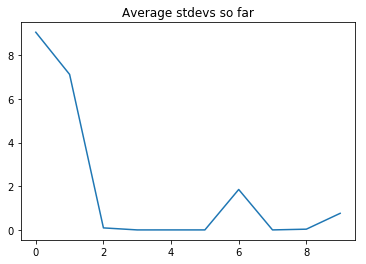

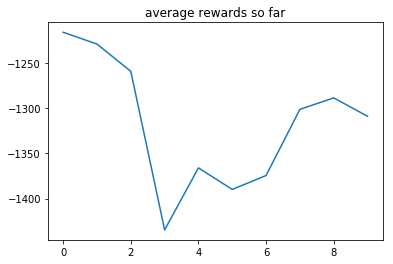

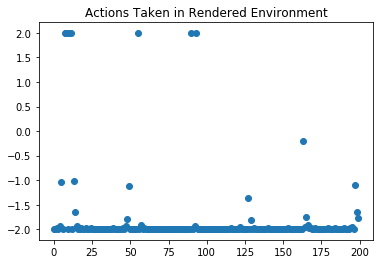

10
average reward:  -1329.533537299951 stdevs: 0.12239302 losses: -0.0697565
11
average reward:  -1365.4370052043876 stdevs: 0.010004341 losses: -6026.723
12
average reward:  -1457.1218847769785 stdevs: 0.01 losses: -0.018806642
13
average reward:  -1451.8411175855563 stdevs: 0.010000882 losses: -0.07899282
14
average reward:  -1411.4125855274178 stdevs: 0.01 losses: 0.06802496
15
average reward:  -1432.9197844682924 stdevs: 0.010000015 losses: 0.068190366
16
average reward:  -1453.2681804695808 stdevs: 0.01 losses: 0.055937957
17
average reward:  -1418.9307741132861 stdevs: 0.010000021 losses: 0.11814668
18
average reward:  -1430.768022872336 stdevs: 0.01 losses: 0.10007017
19
average reward:  -1453.176894494132 stdevs: 0.010000004 losses: 0.030497698
Rewards from rendering: -1507.9531241540403


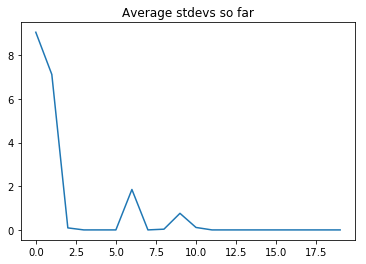

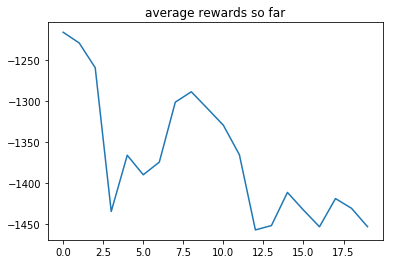

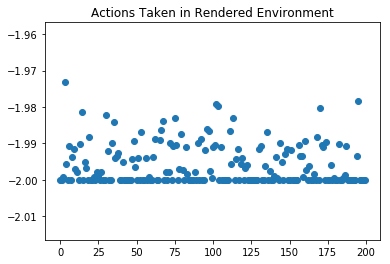

20
average reward:  -1429.1932284001734 stdevs: 0.010000004 losses: 0.26529765
21
average reward:  -1403.1707181156698 stdevs: 0.01 losses: 0.043501806
22
average reward:  -1468.7383383411675 stdevs: 0.010000003 losses: 0.019622069
23
average reward:  -1459.0580678851966 stdevs: 0.009999999 losses: 0.020993542
24
average reward:  -1412.781616087475 stdevs: 0.010000004 losses: 0.04885467
25
average reward:  -1416.1891969760793 stdevs: 0.009999999 losses: -0.087020546
26
average reward:  -1399.9130781134577 stdevs: 0.009999999 losses: 0.08505575
27
average reward:  -1452.9984600564733 stdevs: 0.0100000035 losses: 0.051295795
28
average reward:  -1436.6383672673599 stdevs: 0.010000003 losses: 0.18551576
29
average reward:  -1453.9644570232722 stdevs: 0.009999999 losses: 0.050146922
Rewards from rendering: -1651.2640272810293


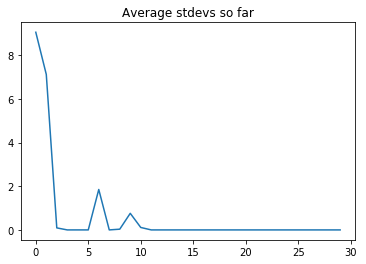

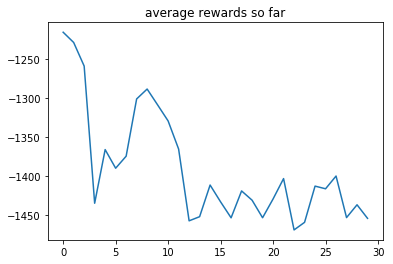

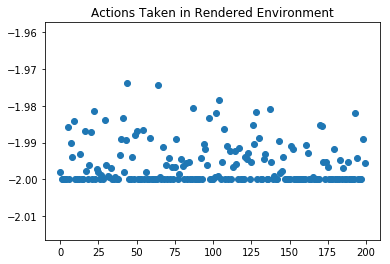

30
average reward:  -1383.6259541860325 stdevs: 0.01 losses: 0.23780435
31
average reward:  -1407.0623347446933 stdevs: 0.010000003 losses: 0.15222181
32
average reward:  -1437.6035190787939 stdevs: 0.010000003 losses: 0.08877254
33
average reward:  -1457.752013040684 stdevs: 0.010000004 losses: 0.03990007
34
average reward:  -1481.375582870493 stdevs: 0.010000015 losses: 0.062609
35
average reward:  -1478.750701948221 stdevs: 0.009999999 losses: 0.020493232
36
average reward:  -1461.8596622466516 stdevs: 0.010000024 losses: 0.06201834
37
average reward:  -1468.6448328745648 stdevs: 0.010000023 losses: -0.02712227
38
average reward:  -1445.3832124282096 stdevs: 0.009999999 losses: 0.14425766
39
average reward:  -1393.499666034851 stdevs: 0.009999999 losses: -0.022421908
Rewards from rendering: -1391.1317644472938


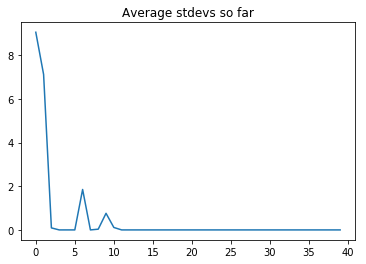

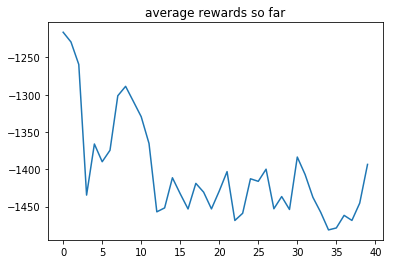

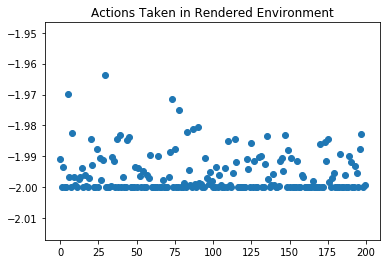

40
average reward:  -1415.244524632431 stdevs: 0.009999999 losses: 0.12137734
41
average reward:  -1468.1312697659698 stdevs: 0.009999999 losses: 0.14001483
42
average reward:  -1457.7527980216528 stdevs: 0.010000007 losses: -0.058136716
43
average reward:  -1430.7157854783436 stdevs: 0.009999999 losses: 0.020489624
44
average reward:  -1407.1151062278566 stdevs: 0.009999999 losses: 0.12634876
45
average reward:  -1429.5272821865294 stdevs: 0.01 losses: -0.06767731
46
average reward:  -1409.9287617259197 stdevs: 0.010000003 losses: 0.101224594
47
average reward:  -1431.7807201560056 stdevs: 0.010000021 losses: 0.034931764
48
average reward:  -1475.2385645384131 stdevs: 0.01 losses: 0.062397525
49
average reward:  -1374.9768654009356 stdevs: 0.01 losses: -0.017911764
Rewards from rendering: -1578.323405532658


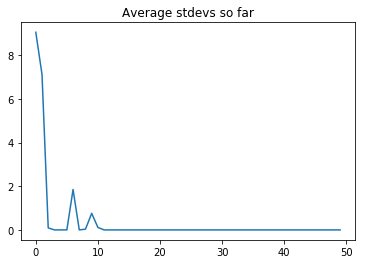

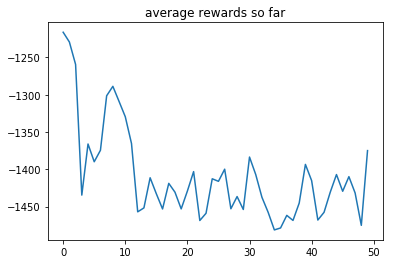

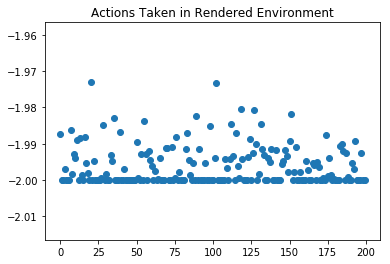

50
average reward:  -1427.9610165772365 stdevs: 0.010000003 losses: 0.04812504
51
average reward:  -1454.6080601884248 stdevs: 0.010000003 losses: 0.17226583


KeyboardInterrupt: 

In [8]:
average_rewards = []
average_stdevs = []
for i in range(10000):
    states, actions, rewards = accumulateData(pendulum, agent)
    #print(actions[0:10])
    #print(rewards[0:10])
    states_pro = []
    actions_pro = []
    rewards_pro = []
    if i % 10 == 0 and i > 0:
        
        plt.figure()
        plt.plot(average_stdevs)
        plt.title("Average stdevs so far")
        plt.figure()
        plt.plot(average_rewards)
        plt.title("average rewards so far")
        
        plottable_actions = renderAgent(pendulum, agent)
        plt.figure()
        plt.scatter(range(len(plottable_actions)), plottable_actions)
        plt.title("Actions Taken in Rendered Environment")
        plt.show()
        plt.close()
    for j in range(len(actions)):
        ret = prepSarData(actions[j], states[j], rewards[j])
        mean_reward = np.average(ret[1])
        stdev_reward = np.std(ret[1])
        states_pro.append(ret[0])
        #actions_pro.append((ret[1] - mean_reward)/stdev_reward)
        actions_pro.append(ret[1])
        rewards_pro.append(ret[2])
        #print(ret[0].shape, ret[1].shape, ret[2].shape)
        #for k in range(10):
        #    agent.trainSarBatches(ret[0], ret[1], ret[2])
    for k in range(5*len(states_pro)):
        train_index = np.random.choice(a=range(len(states_pro)))
        ret = agent.trainSarBatches(states_pro[train_index], actions_pro[train_index], rewards_pro[train_index])
        if np.isnan(ret[0]):
            print("Received nan loss, stopping training.")
            pendulum.close()
            sys.exit(-1)
    print(i)
    average_reward = np.average([sum(r) for r in rewards])
    print("average reward: ", average_reward, "stdevs:", np.average(np.squeeze(ret[2])), "losses:", np.average(np.squeeze(ret[0])))
    average_stdevs.append(np.average(np.squeeze(ret[2])))
    average_rewards.append(average_reward)

plt.figure()
plt.plot(average_rewards)
plt.show()
pendulum.close()

In [ ]:
help(pendulum.close)

In [ ]:
help(tf.math.maximum)

In [ ]:
help(tf.sqrt)